# Introduction to Text Classification
---


## _Zichen Wang_



## _Ma'ayan Lab Meeting_

## _May 27th, 2016_

---

## 0. Motivations

The [Gene Expression Omnibus (GEO)](http://www.ncbi.nlm.nih.gov/geo/) is arguably the largest repository of gene expression datasets. However, most of the datasets deposited on GEO were not well annotated and classified. Hence we launched crowdsourcing microtasks on the [BD2K-LINCS-DCIC Crowdsourcing Portal](http://maayanlab.net/crowdsourcing/) to recruit humans to read through the descriptions on GEO datasets 

We have collected thousands of gene expression signatures from NCBI's GEO studies. Apart from gene expression data, the crowdsourcing approach also provided us with human labeled text documents in two levels: 
1. GEO study documents (an example: [GSE12609](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE12609)) were labeled as one of the three:  
    1. gene perturbation study
    2. disease study
    3. drug perturbation study

2. GEO sample documents (an example: [GSM315884](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM315884)) were labeled as one of the two:
    1. Control
    2. Experimental/Perturbation
    
We can then extract features from the natural languages associated with GSEs and GSMs to predict their labels using classification approaches to scale up the the processes of dataset annotation and signature extraction.

---

## Overview of this presentation/tutorial
1. Prepare some data ([0_prepare_data]())
2. Natural Language Processing Basics
3. Text Classification
    + Applications
    + Defination
    + Methods
        1. Bag-of-words
        2. LSA
        3. Word2vec and Text embedding ([Word2Vec]())
        4. Paragraph vector ([4_Doc2vec]())
        5. RNN? ([5_RNN]())

In [17]:
import cPickle as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
RNG = 2016

# for language processing
from nltk.tokenize import (RegexpTokenizer, WordPunctTokenizer, TreebankWordTokenizer)
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud

# for classification
from sklearn.metrics import (f1_score, log_loss, accuracy_score)
from sklearn import (naive_bayes, ensemble, svm)
import xgboost as xgb

from sklearn.pipeline import Pipeline

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from utils import evaluate_clf

# 1. Natural Language Processing Basics - Text normalizations

##  1.1. Word Tokenization: segmenting words in running text
+ **Token**: a word, phrase, symbol, or other meaningful elements in a running text.
+ Tokenization is not a trival problem:
    + Finland's capital
    + What're, I'm, isn't
    + state-of-the-art
    + Lowercase
    + New York
    + Ph.D
+ Other languages is even harder!
    + **French**: l'ensemble -> un ensemble
    + **German**: Rindfleischetikettierungsueberwachungsaufgabenuebertragungsgesetz, meaning "law delegating beef label monitoring", [the longest German word](http://www.bbc.com/news/world-europe-22762040).
    + **Chinese**: 自然語言處理是人工智慧和語言學領域的分支學科   
    `自然 語言 處理 是 人工智慧 和 語言學 領域 的 分支 學科`   
    `Natural language processing is artificial intelligence and linguistics 's branch field`

---

Demonstration of different tokenization algorithms:

In [3]:
example_text = """
Finland's capital, what're, I'm, state-of-the-art San Francisco Ph.D post-injury
"""
for tokenizer in [
    RegexpTokenizer(r"(?u)\b\w\w+\b"), # white space tokenizer
    WordPunctTokenizer(),
    TreebankWordTokenizer()
                 ]:
    print '-' * 10
    print tokenizer
    print tokenizer.tokenize(example_text)


----------
RegexpTokenizer(pattern='(?u)\\b\\w\\w+\\b', gaps=False, discard_empty=True, flags=56)
['Finland', 'capital', 'what', 're', 'state', 'of', 'the', 'art', 'San', 'Francisco', 'Ph', 'post', 'injury']
----------
WordPunctTokenizer(pattern=u'\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=56)
['Finland', "'", 's', 'capital', ',', 'what', "'", 're', ',', 'I', "'", 'm', ',', 'state', '-', 'of', '-', 'the', '-', 'art', 'San', 'Francisco', 'Ph', '.', 'D', 'post', '-', 'injury']
----------
['Finland', "'s", 'capital', ',', 'what', "'re", ',', 'I', "'m", ',', 'state-of-the-art', 'San', 'Francisco', 'Ph.D', 'post-injury']


In [2]:
# load the labeled df
df = pd.read_csv('data/Labeled_GSEs_texts_with_labels.csv').set_index('id')
df = df.fillna('')
print df.shape
df.head()

(1785, 5)


,Series_summary,Series_title,label,label_code,split
id,,,,,
GSE1001,Sprague-Dawley rat retina post-injury and cont...,retina injury timecourse,dz,1,0
GSE10064,This study aims to determine if global gene ex...,Gene expression in immortalized B-lymphocytes ...,dz,1,0
GSE10082,Conventional biochemical and molecular techniq...,Aryl Hydrocarbon Receptor Regulates Distinct D...,gene,2,0
GSE1009,Gene expression profiling in glomeruli from hu...,Diabetic nephropathy,dz,1,0
GSE1010,RNA samples prepared from lymphoblastic cells ...,FCHL study,dz,1,0


## 1.2. Word normalization
+ **Lemma**: words with the same stem, e.g. `dog` and `dogs`.
+ **Lemmatization**: reduce the variant forms to the base form
    + dogs -> dog
    + am, are, is -> be
+ **Stem**: the core meaning-bearing unit of a word
+ **Stemming**: reduce terms to their stems, a simpler form of Lemmatization.
    + automates, automatic, automation -> automat

+ Differences between **Lemmatization** and **Stemming** [(to read more)](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)   
**Stemming** returns the stems of words.    
**Lemmatization** returns the dictionary form of word.

---

Demonstration of stemming and Lemmatization:

In [4]:
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b") # white space tokenizer

stemmer = PorterStemmer()
lmmr = WordNetLemmatizer()

doc = df.ix[1]['Series_summary']
print 'Original document: \n"%s"' % doc

tokens = tokenizer.tokenize(doc)
print '\nAfter tokenizing:', tokens

stems = [stemmer.stem(t) for t in tokens]
print '\nAfter stemming:',  stems

lemmas = [lmmr.lemmatize(t) for t in tokens]
print '\nAfter lemantization:',  lemmas

Original document: 
"This study aims to determine if global gene expression and transcription factor networks in B-lympocytes of siblings with MS were different from healthy siblings. Keywords: Multiple sclerosis, sibling comparisons"

After tokenizing: ['This', 'study', 'aims', 'to', 'determine', 'if', 'global', 'gene', 'expression', 'and', 'transcription', 'factor', 'networks', 'in', 'lympocytes', 'of', 'siblings', 'with', 'MS', 'were', 'different', 'from', 'healthy', 'siblings', 'Keywords', 'Multiple', 'sclerosis', 'sibling', 'comparisons']

After stemming: [u'Thi', u'studi', u'aim', u'to', u'determin', u'if', u'global', u'gene', u'express', u'and', u'transcript', u'factor', u'network', u'in', u'lympocyt', u'of', u'sibl', u'with', u'MS', u'were', u'differ', u'from', u'healthi', u'sibl', u'Keyword', u'Multipl', u'sclerosi', u'sibl', u'comparison']

After lemantization: ['This', 'study', u'aim', 'to', 'determine', 'if', 'global', 'gene', 'expression', 'and', 'transcription', 'factor',

Here we tokenize the texts in the `Series_summary` column

In [8]:
preprocess_func = lambda x: ' '.join( tokenizer.tokenize(x) )
df['Series_summary'] = df['Series_summary'].apply(preprocess_func)

(-0.5, 1199.5, 799.5, -0.5)

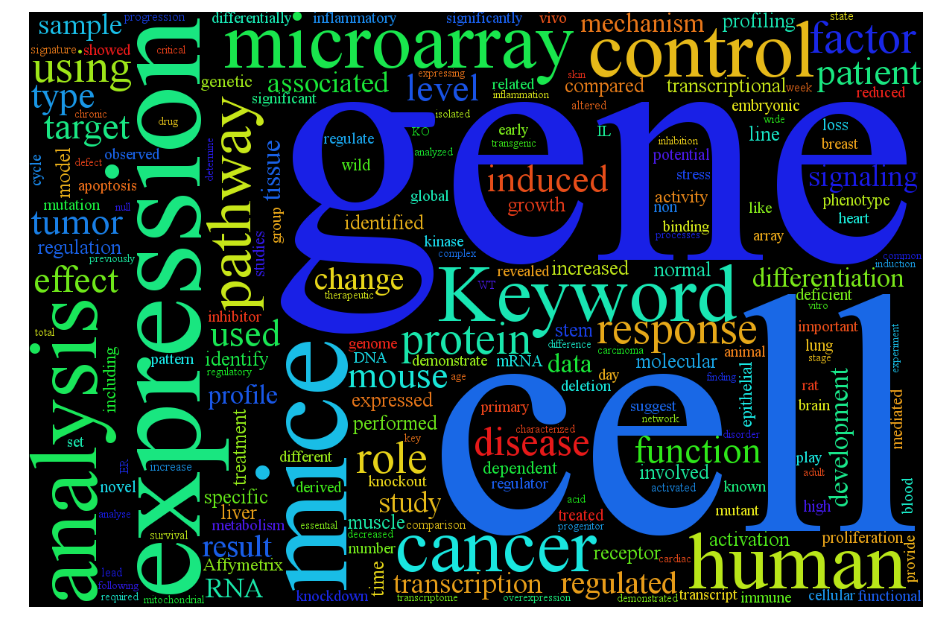

In [23]:
# Visualize the tokens in 'Series_summary' using WordCloud
fig, ax = plt.subplots(figsize=(16,16))
texts = ' '.join(df['Series_summary'].tolist())
wordcloud = WordCloud(width=1200, height=800, stopwords=ENGLISH_STOP_WORDS).generate(texts)
ax.imshow(wordcloud)
ax.axis("off")

# 2. Text classification
+ ## Applications
    1. Email spam detection
    2. Authorship attribution, e.g. Madison, Hamilton, [The Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers)
    3. Gender identification 
    4. Movie review
    5. Topic of scientific articles
    6. Sentiment analysis

+ ## Defination:
    + Input:
        + a document: `d`
        + a fixed set of classes: `C = {c_1, c_2, ...}`
        + a training set of `m` human-labeled documents: `(d_1,c_1), (d_m, c_m) `
    + Output:
        + a predicted probabilities: `p = (p_1, p_2, ...)` corresponding to the set of classes

+ ## Methods
    1. Bag-of-words
    2. LSA
    3. Text embedding (Word2vec)
    4. Paragraph vector
    5. RNN?


## 2.1. Bag-of-words
+ N-gram: a contiguous sequence of `n` items (tokens) from a given sequence of text:
    + n=1, unigram `[This, study, aim, to, ...]`
    + n=2, bigram `[(This, study), (study aim), (aim, to), ...]`
    + n=3, trigram `[(This, study, aim), (study, aim, to), ...]`
    + ...



We use [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to count the words in each document and generate a sparse word count matrix with the shape = (n_documents, n_tokens)

In [9]:
# count tokens 
ctvec = CountVectorizer(min_df=1,
                        max_df=0.8, # max document frequency, words with higher frequency than this will be ignored  
                        max_features=None, 
                        strip_accents='unicode', 
                        decode_error='ignore',
                        lowercase=True,
                        tokenizer=None,
                        analyzer='word', 
                        ngram_range=(1, 2), # only keep uni-grams
                        binary=True, # whether to return binary numbers or word counts
                        stop_words='english')

X = ctvec.fit_transform(df['Series_summary'])
print X.shape

(1785, 115703)


In [10]:
clf = naive_bayes.BernoulliNB()
y = df['label_code'].values

scores = evaluate_clf(clf, X, y, df['split'])
print scores.mean(axis=0)

f1           0.476865
accuracy     0.612329
logloss     13.248159
dtype: float64


/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
# count tokens 
ctvec = CountVectorizer(min_df=1,
                        max_df=1000, # max document frequency, words with higher frequency than this will be ignored  
                        max_features=None, 
                        strip_accents='unicode', 
                        decode_error='ignore',
                        lowercase=True,
                        tokenizer=None,
                        analyzer='word', 
                        ngram_range=(1, 2), # only keep uni-grams
                        binary=False, # whether to return binary numbers or word counts
                        stop_words='english')

X = ctvec.fit_transform(df['Series_summary'])
print X.shape

(1785, 115701)


In [12]:
clf = naive_bayes.MultinomialNB()

scores = evaluate_clf(clf, X, y, df['split'])
print scores.mean(axis=0)

f1          0.795405
accuracy    0.807280
logloss     3.095285
dtype: float64


## Latent semantic analysis


In [15]:
tfidf = TfidfVectorizer(min_df=1, max_df=1000, 
                        max_features=None, strip_accents='unicode', 
                        decode_error='ignore',
                        analyzer='word', 
                        ngram_range=(1, 2), 
                        use_idf=True, smooth_idf=True, 
                        sublinear_tf=True, stop_words = 'english')
svd = TruncatedSVD(n_components=90, algorithm='randomized', n_iter=5, random_state=RNG, tol=0.0)

pipeline = Pipeline([
        ('tfidf', tfidf),
        ('svd', svd)
    ])

X = pipeline.fit_transform(df['Series_summary'])
print X.shape

(1785, 100)


In [16]:
clf = xgb.XGBClassifier(n_estimators=1000, colsample_bytree=1, 
                         learning_rate=0.05, max_depth=8, subsample=0.9, 
                         min_child_weight=1, seed=RNG, nthread=4, silent=0)

scores = evaluate_clf(clf, X, y, df['split'])
print scores.mean(axis=0)

f1          0.806085
accuracy    0.813997
logloss     0.621938
dtype: float64


In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=2000, criterion='entropy', 
                                     max_depth=None, random_state=RNG, n_jobs=4, verbose=0)
et = ensemble.ExtraTreesClassifier(n_estimators=1500, criterion='entropy', max_depth=None, 
                                   random_state=RNG, n_jobs=4, verbose=0)
svc = svm.SVC(C=100, kernel='rbf', probability=True, random_state=RNG, verbose=0)

for clf in [rf, et, svc]:
    scores = evaluate_clf(rf, X, y, df['split'])
    print clf
    print scores.mean(axis=0)